# Evaluation and Analysis of Confidence-Aware Scoring Measures


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm

from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import numpy as np

tqdm.pandas()

data_dir = Path('../../data')

In [ ]:
# load original English uses data, from Organisciak et al. 2023
datasets = {}
for split in ['test', 'train']:
    datasets[split] = pd.read_json(data_dir/ 'ocsai1'/ f'finetune-gt_main2_prepared_{split}.jsonl', lines=True)
    def parse_prompt(p):
        parts = p.split('\n')
        prompt = parts[0].split(':', 1)[1]
        response = parts[1].split(':', 1)[1]
        return pd.Series({'prompt': prompt, 'response': response})
    datasets[split][['item', 'response']] = datasets[split]['prompt'].apply(parse_prompt)
    datasets[split]['target'] = pd.to_numeric(datasets[split]['completion']).div(10)
    datasets[split]['type'] = 'uses'
    datasets[split].item.value_counts()

data = datasets['test']
data.item.value_counts()

item
brick         771
box           431
knife         347
rope          295
paperclip     232
bottle        115
book           81
pants          67
tire           66
sock           65
spoon          64
lightbulb      60
ball           57
table          57
fork           56
pencil         54
shoe           53
shovel         52
toothbrush     50
hat            50
backpack        7
Name: count, dtype: int64

# Score

## Score Alternate Uses with Ocsai Models

*wait! Can't use the all data model since it's seen a lot of data, and can't use ocsai 1.5 since it's seen different splits. Need to use the exact ocsai 1 data test/train to ensure fairness*

Two scoring options: legacy completions models (like babbage2 and davinci2), and newer chat models. Legacy models can go up to 5 completions deep, but are more stable at temp=0. Chat models are more variable, but can have log probs up to 20.

Use the legacy first.

In [10]:
# Ocsai-based scoring - for this, you need a custom fine-tuned model on your OpenAI account
# For scoring with a vanilla GPT model, see LogProbsGPT4o.ipynb
from ocsai.inference import Classic_Scorer, Chat_Scorer
from ocsai.prompter import Ocsai1_Chat_Prompter
scorer = Classic_Scorer()
chatscorer = Chat_Scorer(prompter=Ocsai1_Chat_Prompter(),
                             model_dict={'ocsai-chatgpt':'ft:gpt-3.5-turbo-1106:peter-organisciak::8fEKk0V6'})

In [11]:
def score_weighted(row, model='ocsai-babbage2', top_probs=5, scorer=scorer):
    cols = dict()
    try:
        scores = scorer.score(row['item'],
                            response=row['response'], 
                            task_type=row['type'],
                            model=model,
                            top_probs=top_probs,
                            progressive_weighted=True)
        scores = sorted(scores, key=lambda x: x['n'])
        
        for s in scores:
            cols[f'score_{s["n"]}'] = s['score']
            cols[f'confidence_{s["n"]}'] = s['confidence']
    except KeyboardInterrupt:
        raise
    except:
        print(f"Problem with {row['prompt']}")
        for s in range(1, top_probs+1):
            cols[f'score_{s}'] = None
            cols[f'confidence_{s}'] = None
    return pd.Series(cols)

score_weighted(data.iloc[0])

score_1         1.500000
confidence_1    0.223339
score_2         1.252240
confidence_2    0.442711
score_3         1.442894
confidence_3    0.594217
score_4         1.490813
confidence_4    0.730335
score_5         1.463426
confidence_5    0.852724
dtype: float64

In [12]:
score_weighted(data.iloc[0], model='ocsai-chatgpt', top_probs=20, scorer=chatscorer).iloc[::2]

score_1     2.000000
score_2     1.939054
score_3     1.892837
score_4     1.940594
score_5     1.965435
score_6     1.932164
score_7     1.966233
score_8     1.971229
score_9     1.962776
score_10    1.961389
score_11    1.970614
score_12    1.960922
score_13    1.954684
score_14    1.961230
score_15    1.952941
score_16    1.956865
score_17    1.953765
score_18    1.956358
score_19    1.960257
score_20    1.961361
dtype: float64

In [ ]:
#test = data.sample(100)
top_probs = 20
model = 'ocsai-chatgpt'
scorer = chatscorer
responses = data.progress_apply(lambda row: score_weighted(row, model=model, top_probs=top_probs, scorer=scorer), axis=1)
data[responses.columns] = responses.values

In [170]:
data.to_csv(data_dir / 'results/logprobs' / f'logprobs_{model}_ocsai1.csv', index=False)

## Score Ocsai 1 Uses, with Plain (Prompted) GPT-4o

In [ ]:
# Create a basic few shot prompt by sorting, taking every nth example, then randomizing
fewshot_sample = datasets['train'].sort_values('completion', ascending=False).iloc[::150].sample(frac=1, random_state=42)
display(fewshot_sample.iloc[0])
print("# examples:", len(fewshot_sample))

import tiktoken
encoding = tiktoken.encoding_for_model('gpt-4o')
example_str = ''
for row in fewshot_sample.prompt.str.strip() + fewshot_sample.completion.astype(str):
    example_str += f"\n{row}\n"

print("# tokens:", len(encoding.encode(example_str)))
print('\n```' + example_str[:140] + '...\n```')


In [ ]:
from ocsai.prompter.ocsai1_chat_prompter import Ocsai1_Chat_Prompter
from ocsai.types import FullScore, ResponseTypes
import textwrap

class GPT_Vanilla_Prompter(Ocsai1_Chat_Prompter):
    sys_msg_text = textwrap.dedent('''
    You score originality in the alternate uses task.

    On a scale of 10-50, judge how original each use is, for the give item, where 10 is 'not at all creative' and 50 is 'very creative'
                                   
    Respond with *JUST* a single number, no other text, just one token score.
                                   
    Here are examples of the task:
    ''' + '\n' + example_str)

    def craft_prompt(self, item, response, task_type='uses', question=None, language='eng'):
        ''' Remove "\nScore:\n" from the legacy format.'''
        prompt = super().craft_prompt(item, response, task_type, question, language)
        return prompt + '\nScore:'

In [ ]:
from ocsai.inference import Chat_Scorer
chatscorer = Chat_Scorer(prompter=GPT_Vanilla_Prompter(),
                             model_dict={'gpt-4o':'gpt-4o-2024-08-06',
                                         'gpt-4o-mini':'gpt-4o-mini-2024-07-18'
                                         }) # o3-mini doesn't allow requesting logprobs; a way to get around this is to generate the '<think>' response, then use 4o to score

def score_weighted(row, model='gpt-4o', top_probs=5, scorer=chatscorer):
    cols = dict()
    try:
        scores = scorer.score(row['item'],
                            response=row['response'], 
                            task_type=row['type'],
                            model=model,
                            top_probs=top_probs,
                            progressive_weighted=True)
        scores = sorted(scores, key=lambda x: x['n'])
        
        for s in scores:
            cols[f'score_{s["n"]}'] = s['score']
            cols[f'confidence_{s["n"]}'] = s['confidence']
    except KeyboardInterrupt:
        raise
    except:
        print(f"Problem with {row['prompt']}")
        for s in range(1, top_probs+1):
            cols[f'score_{s}'] = None
            cols[f'confidence_{s}'] = None
        raise
    return pd.Series(cols)

print(data.iloc[0])
score_weighted(data.iloc[0], top_probs=20)

In [ ]:
top_probs = 20
model = 'gpt-4o'
scorer = chatscorer
responses = data.progress_apply(lambda row: score_weighted(row, model=model, top_probs=top_probs, scorer=scorer), axis=1)
data[responses.columns] = responses.values

In [ ]:
data.to_csv(data_dir / 'results/logprobs' / f'logprobs_{model}_ocsai1.csv', index=False)

# Analysis

## Prep Data

In [101]:
collector = []
id_vars = ['run','type', 'item', 'response', 'target']

for model in ['ocsai-babbage2', 'ocsai-davinci2', 'ocsai-chatgpt', 'gpt-4o', 'gpt-4o-mini']:
    df = pd.read_csv(data_dir / 'results/logprobs' / f'logprobs_{model}_ocsai1.csv')
    df['run'] = model

    # when an item doesn't have a score for the n*th contributor
    # (e.g. looking at top_logprobs=5 but only 4 are provided), 
    # use the previous slots score.

    max_contributors = max([int(c.split('_')[1]) for c in df.columns if c.startswith('score')])
    for i in range(1, max_contributors+1):
        if (i - 1) <= 0:
            continue
        for cat in ['score', 'confidence']:
            prev, col = f'{cat}_{i-1}', f'{cat}_{i}'
            df.loc[df[col].isna(), col] = df.loc[df[col].isna(), prev]

    collector.append(df)
df = pd.concat(collector)

scores_long = df.melt(id_vars=id_vars,
        value_vars=[c for c in df.columns if c.startswith('score_')],
        var_name='contributors',
        value_name='score')

confidences_long = df.melt(id_vars=id_vars,
        value_vars=[c for c in df.columns if c.startswith('confidence_')],
        var_name='contributors',
        value_name='confidence')

scores_long.contributors = scores_long.contributors.str.extract(r'(\d+)').astype(int)
confidences_long.contributors = confidences_long.contributors.str.extract(r'(\d+)').astype(int)

long = scores_long.merge(confidences_long, on=id_vars + ['contributors']).dropna()
# for fairness, keep same precision
long['score'] = long['score'].round(1)

display(long.dropna()['run'].value_counts())
long.sample(5)

run
ocsai-chatgpt     60600
gpt-4o            60600
gpt-4o-mini       60600
ocsai-babbage2    15150
ocsai-davinci2    15150
Name: count, dtype: int64

,run,type,item,response,target,contributors,score,confidence
1086,ocsai-babbage2,uses,brick,put behind the tire of your car on a hill,1.8,1,1.5,0.157564
205471,ocsai-chatgpt,uses,box,fill with pillows and jump inside,2.3,18,1.7,0.995673
178193,gpt-4o,uses,brick,exfoliant (scrub dead skin cells),3.0,16,3.5,0.890799
220286,ocsai-chatgpt,uses,hat,Be Mario,3.0,19,2.5,0.951511
159501,ocsai-chatgpt,uses,shoe,to plant a tree,3.8,15,3.6,0.905223


In [102]:
# calculate RMSE and Pearson r for target vs score, by group
def evaluate(x):
    r = pearsonr(x['target'], x['score'])[0] # the second item is p-value, which at this scale doesn't need reporting (since it's only not significant when r is very, very low)
    rmse = np.sqrt(mean_squared_error(x['target'], x['score']))
    n = len(x)
    return pd.Series({'r': np.round(r, 3), 'RMSE':np.round(rmse,4), 'n': n})

## Weighted Measure Eval

In [104]:
evaluated = long.dropna().groupby(['run', 'contributors'])[['target', 'score']].apply(evaluate)
display(evaluated.head(40))
evaluated.iloc[40:]

r    RMSE       n
run         contributors                       
gpt-4o      1             0.607  0.7656  3030.0
            2             0.618  0.7497  3030.0
            3             0.620  0.7451  3030.0
            4             0.621  0.7404  3030.0
            5             0.622  0.7381  3030.0
            6             0.623  0.7360  3030.0
            7             0.623  0.7330  3030.0
            8             0.624  0.7319  3030.0
            9             0.625  0.7308  3030.0
            10            0.626  0.7288  3030.0
            11            0.626  0.7283  3030.0
            12            0.625  0.7281  3030.0
            13            0.626  0.7269  3030.0
            14            0.627  0.7257  3030.0
            15            0.626  0.7264  3030.0
            16            0.626  0.7259  3030.0
            17            0.626  0.7260  3030.0
            18            0.627  0.7253  3030.0
            19            0.627  0.7246  3030.0
            20            0.627  0.7240  3030.0
gpt-4o-mini 1             0.508  0.9895  3030.0
            2             0.514  0.9755  3030.0
            3             0.518  0.9681  3030.0
            4             0.520  0.9648  3030.0
            5             0.520  0.9643  3030.0
            6             0.521  0.9629  3030.0
            7             0.521  0.9623  3030.0
            8             0.522  0.9615  3030.0
            9             0.521  0.9613  3030.0
            10            0.522  0.9603  3030.0
            11            0.522  0.9601  3030.0
            12            0.523  0.9596  3030.0
            13            0.523  0.9592  3030.0
            14            0.523  0.9591  3030.0
            15            0.523  0.9591  3030.0
            16            0.523  0.9589  3030.0
            17            0.523  0.9588  3030.0
            18            0.523  0.9587  3030.0
            19            0.523  0.9586  3030.0
            20            0.523  0.9586  3030.0

r    RMSE       n
run            contributors                       
ocsai-babbage2 1             0.722  0.6614  3030.0
               2             0.736  0.6345  3030.0
               3             0.741  0.6218  3030.0
               4             0.747  0.6099  3030.0
               5             0.749  0.6042  3030.0
ocsai-chatgpt  1             0.781  0.5990  3030.0
               2             0.801  0.5571  3030.0
               3             0.809  0.5388  3030.0
               4             0.813  0.5301  3030.0
               5             0.816  0.5235  3030.0
               6             0.817  0.5198  3030.0
               7             0.818  0.5160  3030.0
               8             0.818  0.5148  3030.0
               9             0.819  0.5117  3030.0
               10            0.819  0.5103  3030.0
               11            0.819  0.5096  3030.0
               12            0.821  0.5067  3030.0
               13            0.821  0.5058  3030.0
               14            0.820  0.5056  3030.0
               15            0.820  0.5054  3030.0
               16            0.820  0.5051  3030.0
               17            0.820  0.5040  3030.0
               18            0.821  0.5037  3030.0
               19            0.820  0.5038  3030.0
               20            0.820  0.5038  3030.0
ocsai-davinci2 1             0.774  0.5653  3030.0
               2             0.788  0.5421  3030.0
               3             0.794  0.5310  3030.0
               4             0.798  0.5238  3030.0
               5             0.799  0.5210  3030.0

In [105]:
# Formatted for Paper
x = evaluated.melt(ignore_index=False, value_vars=['r', 'RMSE'], var_name='metric', value_name='value').reset_index()
x = x.query('contributors <= 5')
x.pivot(index=['contributors'], columns=['run', 'metric'], values=['value'])

value                                                          \
run          gpt-4o gpt-4o-mini ocsai-babbage2 ocsai-chatgpt ocsai-davinci2   
metric            r           r              r             r              r   
contributors                                                                  
1             0.607       0.508          0.722         0.781          0.774   
2             0.618       0.514          0.736         0.801          0.788   
3             0.620       0.518          0.741         0.809          0.794   
4             0.621       0.520          0.747         0.813          0.798   
5             0.622       0.520          0.749         0.816          0.799   

                                                                              
run           gpt-4o gpt-4o-mini ocsai-babbage2 ocsai-chatgpt ocsai-davinci2  
metric          RMSE        RMSE           RMSE          RMSE           RMSE  
contributors                                                                  
1             0.7656      0.9895         0.6614        0.5990         0.5653  
2             0.7497      0.9755         0.6345        0.5571         0.5421  
3             0.7451      0.9681         0.6218        0.5388         0.5310  
4             0.7404      0.9648         0.6099        0.5301         0.5238  
5             0.7381      0.9643         0.6042        0.5235         0.5210

Measure stability

It looks near-monotonic:

<Axes: xlabel='contributors'>

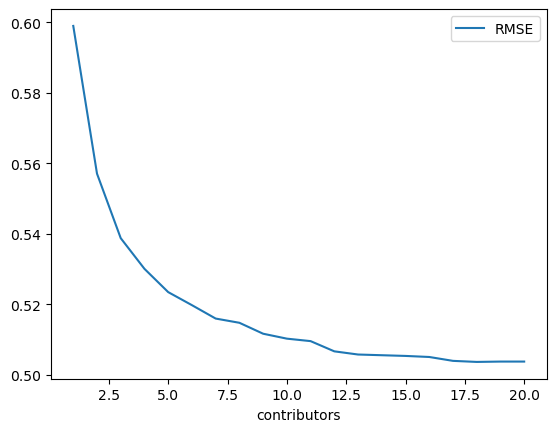

In [112]:
avg_conf = long[long.run == 'ocsai-chatgpt'].groupby('contributors', as_index=False)[['confidence']].mean()
avg_conf.contributors = avg_conf.contributors.astype(int)
#ax = avg_conf.plot(x='contributors', y='confidence', secondary_y=True, color='red', alpha=.3, style='-')

#evaluated.loc['ocsai-chatgpt'].reset_index().plot(x='contributors', y='RMSE', ax=ax)
evaluated.loc['ocsai-chatgpt'].reset_index().plot(x='contributors', y='RMSE')

## Confidence Eval

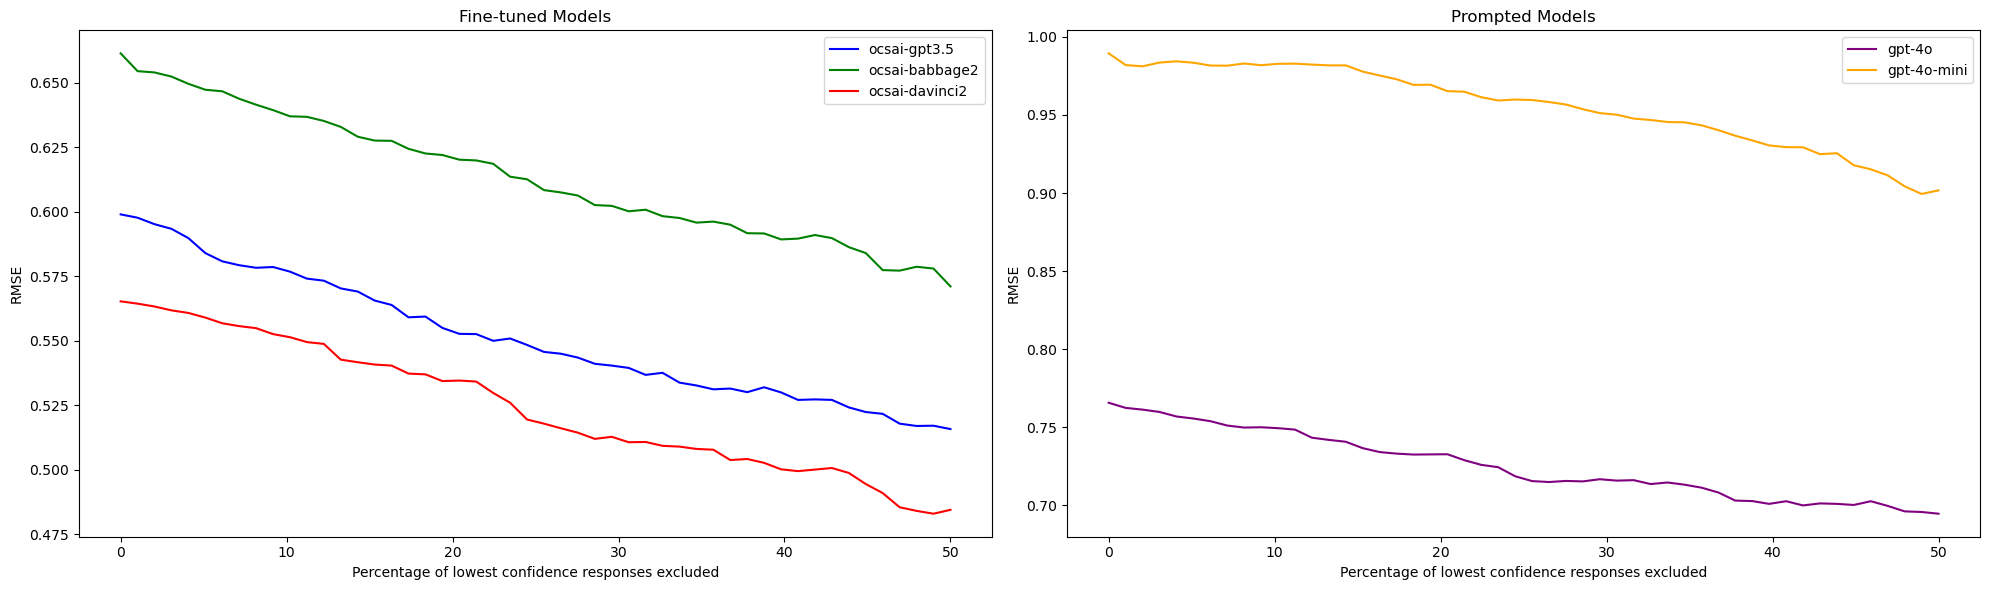

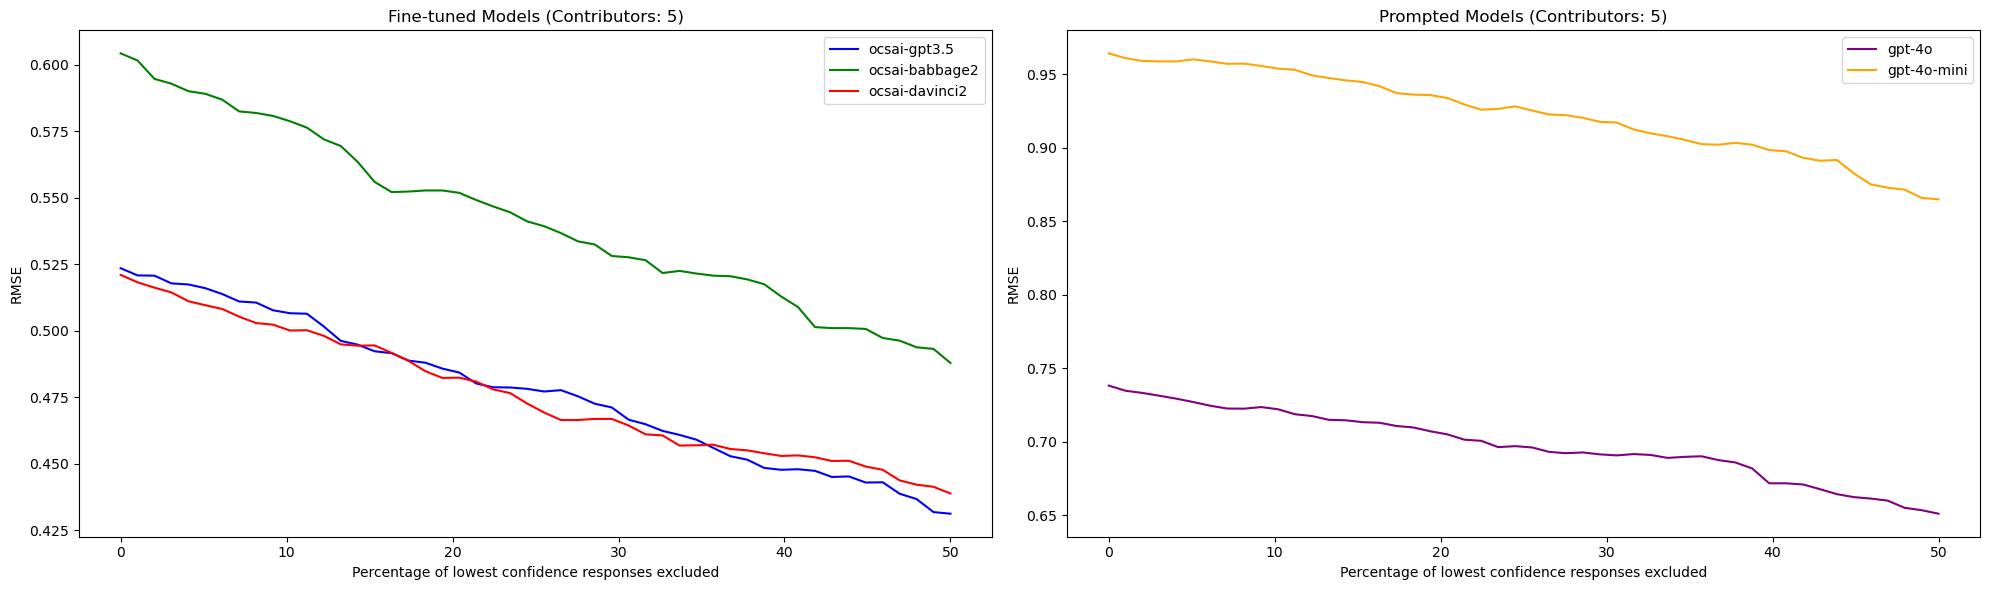

In [115]:
# Plot confidence threshold analysis for all models
n_bins = 10
top_probs = 5

# Split models into two groups
traditional_models = ['ocsai-gpt3.5', 'ocsai-babbage2', 'ocsai-davinci2']  # renamed from ocsai-chatgpt
gpt4_models = ['gpt-4o', 'gpt-4o-mini']

model_groups = {
    'Fine-tuned Models': {'models': traditional_models, 'colors': ['blue', 'green', 'red']},
    'Prompted Models': {'models': gpt4_models, 'colors': ['purple', 'orange']}
}

# For each contributor count
for i in [1, 5]:
    # Create a single figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    # Plot each group in its respective subplot
    for (group_name, group_info), ax in zip(model_groups.items(), [ax1, ax2]):
        # For each model in the group
        for model, color in zip(group_info['models'], group_info['colors']):
            # Handle the model name replacement in the data
            data_model = 'ocsai-chatgpt' if model == 'ocsai-gpt3.5' else model
            subset = long[(long.contributors == i) & (long['run'] == data_model)].dropna().copy()
            
            # Calculate threshold performance
            rows = []
            percentiles = np.linspace(0, 50, 50)
            
            for percentile in percentiles:
                threshold = subset['confidence'].quantile(percentile/100)
                filtered_subset = subset[subset['confidence'] >= threshold]
                if len(filtered_subset) <= 100:
                    continue
                row = evaluate(filtered_subset)
                row['percentile_dropped'] = percentile
                rows.append(row)
                
            df = pd.DataFrame(rows)
            # Use the display model name (with ocsai-gpt3.5) instead of the data model name
            df.plot(x='percentile_dropped', y='RMSE', color=color, label=model, ax=ax)
        
        ax.set_xlabel("Percentage of lowest confidence responses excluded")
        ax.set_ylabel("RMSE")
        ax.legend()
        if i > 1:
            ax.set_title(f"{group_name} (Contributors: {i})")
        else:
            ax.set_title(f"{group_name}")
    
    plt.tight_layout()
    plt.show()

What's a reasonable number? Maybe one-fifth? If we commit to dropping the bottom fifth of auto-scored responses what is the performance (in RMSE and r, by model)?

In [107]:
# Calculate baseline and filtered metrics for comparison
results = []
for model in ['ocsai-chatgpt', 'ocsai-babbage2', 'ocsai-davinci2', 'gpt-4o', 'gpt-4o-mini']:
    for i in range(1, 6):  # Looking at first 5 contributors
        subset = long[(long.contributors == i) & (long['run'] == model)].dropna().copy()
        
        # Baseline metrics (all data)
        baseline_metrics = evaluate(subset)
        baseline_metrics['model'] = model
        baseline_metrics['contributors'] = i
        baseline_metrics['filtered'] = False
        results.append(baseline_metrics)
        
        # Filtered metrics (top 80%)
        threshold = subset['confidence'].quantile(0.2)
        filtered = subset[subset['confidence'] >= threshold]
        filtered_metrics = evaluate(filtered)
        filtered_metrics['model'] = model
        filtered_metrics['contributors'] = i
        filtered_metrics['filtered'] = True
        results.append(filtered_metrics)

results = pd.DataFrame(results)

print("Single contributor performance (baseline vs dropping bottom 20%):")
display(results.query('contributors == 1')
        .drop(columns=['contributors'])
        .set_index(['model', 'filtered'])
        .sort_index())

print("\nFive contributor performance (baseline vs dropping bottom 20%):")
display(results.query('contributors == 5')
        .drop(columns=['contributors'])
        .set_index(['model', 'filtered'])
        .sort_index())

Single contributor performance (baseline vs dropping bottom 20%):


r    RMSE       n
model          filtered                       
gpt-4o         False     0.607  0.7656  3030.0
               True      0.656  0.7329  2424.0
gpt-4o-mini    False     0.508  0.9895  3030.0
               True      0.533  0.9666  2424.0
ocsai-babbage2 False     0.722  0.6614  3030.0
               True      0.765  0.6206  2424.0
ocsai-chatgpt  False     0.781  0.5990  3030.0
               True      0.822  0.5544  2424.0
ocsai-davinci2 False     0.774  0.5653  3030.0
               True      0.809  0.5348  2424.0


Five contributor performance (baseline vs dropping bottom 20%):


r    RMSE       n
model          filtered                       
gpt-4o         False     0.622  0.7381  3030.0
               True      0.673  0.7062  2424.0
gpt-4o-mini    False     0.520  0.9643  3030.0
               True      0.545  0.9358  2424.0
ocsai-babbage2 False     0.749  0.6042  3030.0
               True      0.795  0.5531  2424.0
ocsai-chatgpt  False     0.816  0.5235  3030.0
               True      0.846  0.4848  2424.0
ocsai-davinci2 False     0.799  0.5210  3030.0
               True      0.838  0.4821  2424.0

In [ ]:
# OLD code - was not good communication.
# split data into x bins based on confidence_1 column, then seen the correlation between score_1 and target at each bin
n_bins = 10
top_probs = 5
model = 'ocsai-chatgpt'
for i in range(1, top_probs+1):
    subset = long[(long.contributors == i) & (long['run'] == model)].dropna().copy()
    print(f"Score {i} correlation with confidence bins")
    confidence_bin = pd.qcut(subset['confidence'], n_bins)
    df = subset.groupby(confidence_bin, observed=False).apply(evaluate)
    display(df)

    # Plot bins
    df['bin'] = range(1, len(df)+1)
    ax = df.plot(x='bin', y='RMSE', kind='bar')
    # second axis is too confusing
    #df.plot(x='bin', y='r', ax=ax, color='red', secondary_y=True)
    ax.set_title(f"Score {i} correlation with confidence bins")

    # consider performance when dropping responses below a threshold
    rows = []
    tenth, ninetieth = subset.confidence.quantile([0.1, 0.9]).tolist()
    thresholds = np.linspace(tenth, ninetieth, 50)
    for threshold in thresholds:
        filtered_subset = subset[subset['confidence'] >= threshold]
        if len(filtered_subset) <= 100:
            row = {'r': None, 'RMSE': None, 'n': len(filtered_subset), 'threshold': threshold}
            continue
        row = evaluate(filtered_subset)
        row['threshold'] = threshold
        rows.append(row)
    df = pd.DataFrame(rows)
    ax = df.plot(x='threshold', y='RMSE', color='blue', kind='line')
    # df.plot(x='threshold', y='n', ax=ax, secondary_y=True, color='red', alpha=0.5, kind='line')
    ax.set_title(f"Performance when dropping responses below threshold")

Ordinary Least Squares - first just for confidence, without including contributors.

In [108]:
from statsmodels.formula.api import ols
for_ols = long.dropna().copy().query('contributors == 1')
for_ols['abs_error'] = abs(for_ols['target'] - for_ols['score'])
model = ols('abs_error ~ C(run) + confidence', data=for_ols).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              abs_error   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     450.0
Date:                Mon, 31 Mar 2025   Prob (F-statistic):               0.00
Time:                        09:45:15   Log-Likelihood:                -9858.5
No. Observations:               15150   AIC:                         1.973e+04
Df Residuals:                   15144   BIC:                         1.977e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [109]:
for_ols.groupby(['run', 'contributors']).abs_error.mean()

run             contributors
gpt-4o          1               0.580627
gpt-4o-mini     1               0.775677
ocsai-babbage2  1               0.486106
ocsai-chatgpt   1               0.434851
ocsai-davinci2  1               0.411221
Name: abs_error, dtype: float64

In [110]:
from statsmodels.formula.api import ols
for_ols = long.dropna().copy()

for_ols['normalized_confidence'] = for_ols.groupby('contributors')['confidence'].transform(
    lambda x: (x - x.mean()) / x.std()
)
for_ols['abs_error'] = abs(for_ols['target'] - for_ols['score'])
model = ols('abs_error ~ C(run) + contributors + normalized_confidence', data=for_ols).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              abs_error   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     5305.
Date:                Mon, 31 Mar 2025   Prob (F-statistic):               0.00
Time:                        09:45:54   Log-Likelihood:            -1.3676e+05
No. Observations:              212100   AIC:                         2.735e+05
Df Residuals:                  212093   BIC:                         2.736e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Since raw confidence values are not comparable between different contributor counts, they were normalized to a z-score. The model was statistically significant and explained 13% of the variance in absolute error. Utilizing more contributors in the score slightly but significantly reduced prediction error. Reference model is gpt-4o. Since confidence is a lossy technique and contributors is not, the two seem conceptually disjoint to model together. It might be misleading for a reader: the confidence explains a disproportiate amount of the variance, so it is a strange way to report on the contributors.

## Ensemble Model Eval

In [11]:
ensemble = long[(long.contributors <= 5) & long.run.isin(['ocsai-davinci2', 'ocsai-chatgpt'])].groupby(['item', 'response', 'target', 'type', 'contributors'], as_index=False).mean(['score', 'confidence'])
ensemble.groupby('contributors').apply(evaluate)

,r,RMSE,n
contributors,,,
1,0.805,0.5378,3030.0
2,0.815,0.5175,3030.0
3,0.820,0.5068,3030.0
4,0.822,0.5013,3030.0
5,0.823,0.4978,3030.0
